In [1]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [2]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [3]:
df.drop_duplicates()

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionDate,MissionNumber,PULOC,DropLoc,...,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal
0,Removal,M,Non-Criminal,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
1,Removal,M,Non-Criminal,No,1.0,38.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
2,Removal,M,Non-Criminal,No,1.0,20.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
3,Removal,M,Non-Criminal,No,1.0,29.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
4,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
5,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
6,Removal,M,Traffic Offense,No,1.0,18.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
7,Removal,M,Non-Criminal,No,1.0,21.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
8,Removal,M,Non-Criminal,No,1.0,23.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False
9,Removal,M,Non-Criminal,No,1.0,19.0,2010-10-01,110003,KIWA,MGGT,...,149.0,La Aurora Airport,Guatemala City,NaN,NaN,NaN,NaN,NaN,Guatemala,False


# Global variables

In [4]:
pre_drop = len(df)
df = df.drop_duplicates()
post_drop = len(df)
assert pre_drop == post_drop

In [5]:
number_of_records = len(df)
print(f'Number of records: {number_of_records}')

Number of records: 1763020


In [6]:
unique_AlienMasterID = len(set(df['AlienMasterID']))
assert sum(df['AlienMasterID'].isnull()) == 0
print(f"Unique AlienMasterID values: {unique_AlienMasterID}")

Unique AlienMasterID values: 1733555


No missing values in ID fields. IDs repeat.

In [7]:
unique_MissionID = len(set(df['MissionID']))
assert sum(df['MissionID'].isnull()) == 0
print(f"Unique MissionID values: {unique_MissionID}")

Unique MissionID values: 14973


In [8]:
unique_MissionNumber = len(set(df['MissionNumber']))
assert sum(df['MissionNumber'].isnull()) == 0
print(f"Unique MissionNumber values: {unique_MissionNumber}")

Unique MissionNumber values: 14973


One to one relationship of MissionID to MissionNumber. These fields seem to be equivalent.

In [9]:
assert sum(df.groupby(['MissionID', 'MissionNumber'])['MissionNumber'].nunique() > 1) == 0
assert sum(df.groupby(['MissionNumber', 'MissionID'])['MissionID'].nunique() > 1) == 0

In [10]:
missions = df.groupby(['MissionDate', 'MissionID', 'MissionNumber', 'PULOC', 'DropLoc'])
mission_segments = len(missions)
print(f"{mission_segments} unique flight segments, grouped by mission and date.")

41247 unique flight segments, grouped by mission and date.


In [11]:
missions['AlienMasterID'].nunique().head(10)

MissionDate  MissionID  MissionNumber  PULOC  DropLoc
2010-10-01   105        110005         KMDT   KAEX       122
             106        110006         KHRL   MGGT        67
                                       KSAT   MGGT        37
             107        110007         KAEX   MHLM        97
             108        110008         KMCI   KAEX        10
                                              KHRL        35
                                       KORD   KAEX        25
                                              KHRL        63
             131        110002         KBFL   KIWA         3
                                              KSAN        21
Name: AlienMasterID, dtype: int64

In [12]:
earliest_record = df['MissionDate'].min()
print(f'Earliest record: {earliest_record}')

Earliest record: 2010-10-01 00:00:00


In [13]:
latest_record = df['MissionDate'].max()
print(f'Earliest record: {latest_record}')

Earliest record: 2018-12-05 00:00:00


In [14]:
number_of_pickup_airports = len(set(df['PULOC']))
number_of_dropoff_airports = len(set(df['DropLoc']))
print(f'Number of pickup airports: {number_of_pickup_airports}')
print(f'Number of dropoff airports: {number_of_dropoff_airports}')

Number of pickup airports: 84
Number of dropoff airports: 207


In [15]:
droplocs_per_fy = df.resample('AS-OCT', on='MissionDate')['DropLoc'].nunique()
pulocs_per_fy = df.resample('AS-OCT', on='MissionDate')['PULOC'].nunique()

In [16]:
expansion = pd.DataFrame({'Pickup Airports': pulocs_per_fy, 'Dropoff Airports': droplocs_per_fy})
expansion.index = expansion.index.year + 1
expansion.index.name = 'FY'

In [17]:
expansion

,Pickup Airports,Dropoff Airports
FY,,
2011,41,69
2012,45,78
2013,46,48
2014,41,62
2015,36,60
2016,39,87
2017,40,85
2018,41,108
2019,31,52


In [18]:
expansion.to_csv('../output/iceair-expansion.csv')

# Most common pickup, dropoff airports

In [19]:
df['air_AirportName'].value_counts().head(10)

Alexandria International Airport                        239911
Brownsville South Padre Island International Airport    204895
Phoenix-Mesa-Gateway Airport                            196150
Valley International Airport                            154138
El Paso International Airport                           136127
San Antonio International Airport                       107434
Columbus Metropolitan Airport                            80797
Harrisburg International Airport                         76348
Laredo International Airport                             56409
Miami International Airport                              55588
Name: air_AirportName, dtype: int64

In [20]:
df['air2_AirportName'].value_counts().head(10)

La Aurora Airport                                       327010
Ramon Villeda Morales International Airport             202955
Alexandria International Airport                        169316
El Salvador International Airport                       157773
Valley International Airport                            148700
Phoenix-Mesa-Gateway Airport                             93892
El Paso International Airport                            87408
Licenciado Benito Juarez International Airport           85584
Brownsville South Padre Island International Airport     66444
San Diego International Airport                          62943
Name: air2_AirportName, dtype: int64

In [21]:
pickup_countries = set(df['air_Country'].dropna())
print(f'Number of pickup countries: {len(pickup_countries)}')

Number of pickup countries: 10


In [22]:
dropoff_countries = set(df['air2_Country'].dropna())
print(f'Number of dropoff countries: {len(dropoff_countries)}')

Number of dropoff countries: 119


In [23]:
all_countries = pickup_countries.union(dropoff_countries)
print(f'Total countries in ICE Air network (including US): {len(dropoff_countries)}')

Total countries in ICE Air network (including US): 119


Top nationalities:

In [24]:
df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(15)

MEXICO                568039
GUATEMALA             421411
HONDURAS              304685
EL SALVADOR           256834
DOMINICAN REPUBLIC     31704
ECUADOR                25688
HAITI                  23308
NICARAGUA              18679
COLOMBIA               14520
JAMAICA                12800
INDIA                   8952
CHINA                   4459
CUBA                    3658
BANGLADESH              2790
SOMALIA                 2659
Name: CountryOfCitizenship, dtype: int64

# Removal versus transfer rates

In [25]:
removal_count = df.loc[df['R-T'] == 'R'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()

In [26]:
transfer_count =  df.loc[df['R-T'] == 'T'].drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts()

In [27]:
transfer_rate = (transfer_count / removal_count).sort_values(ascending = False)

In [28]:
country = "GUATEMALA"
print(transfer_count[country])
print(removal_count[country])

94628
326783


In [29]:
valid_comparisons = transfer_rate[transfer_rate != np.inf]
valid_comparisons.head()

VENEZUELA      449.000000
COSTA RICA     249.000000
BRAZIL         123.000000
NEPAL          100.277778
NEW ZEALAND    100.000000
Name: CountryOfCitizenship, dtype: float64

In [30]:
valid_comparisons[country]

0.28957442706627945

# Finding repeat `AlienMasterID` values

In [31]:
count = df.groupby(['AlienMasterID']).size().reset_index(name='count')

count.set_index('AlienMasterID', inplace=True)

df.set_index('AlienMasterID', inplace=True)

df = df.join(count, how='left')

more_than_one = df['count'] > 1

multiple_alienID = df[more_than_one]

multiple_alienID.to_csv('../output/multiple_alienID.csv.gz', compression='gzip', sep='|')

In [32]:
df.reset_index(inplace=True)

# Most common, most passenger flight paths

In [33]:
most_common_flight_path = df.groupby(['PULOC','DropLoc'])['MissionID'].nunique().idxmax()
most_common_flight_path_count =  df.groupby(['PULOC','DropLoc'])['MissionID'].nunique()[most_common_flight_path]
most_passenger_flight_path = df.groupby(['PULOC','DropLoc'])['AlienMasterID'].nunique().idxmax()
most_passenger_flight_path_count = df.groupby(['PULOC','DropLoc'])['AlienMasterID'].nunique()[most_passenger_flight_path]

In [34]:
print(f'Most frequent flight path: {most_common_flight_path}, {most_common_flight_path_count} missions')
print(f'Flight path with most passengers: {most_passenger_flight_path}, {most_passenger_flight_path_count} passengers')

Most frequent flight path: ('KOAK', 'KSAN'), 919 missions
Flight path with most passengers: ('KBRO', 'MGGT'), 91714 passengers


In [35]:
most_passenger_flight_path_trips = df.groupby(['PULOC','DropLoc'])['MissionNumber'].nunique()[most_passenger_flight_path]

In [36]:
cost_per_hour = 7785

In [37]:
kbro_to_mggt_duration_hrs = 5

In [38]:
most_passenger_flight_path_trips * kbro_to_mggt_duration_hrs * cost_per_hour

35694225

# Trend charts

In [39]:
removal_df = df.loc[df['R-T'] == 'R']
transfer_df = df.loc[df['R-T'] == 'T']
removal_df.set_index('MissionDate', inplace=True)
transfer_df.set_index('MissionDate', inplace=True)

In [40]:
annual_removals = removal_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total removals', inplace=True)
annual_transfers = transfer_df['AlienMasterID'].resample('AS-OCT').nunique().rename('Total transfers', inplace=True)
annual_removal_flights = removal_df['MissionID'].resample('AS-OCT').nunique()
annual_transfer_flights = transfer_df['MissionID'].resample('AS-OCT').nunique()

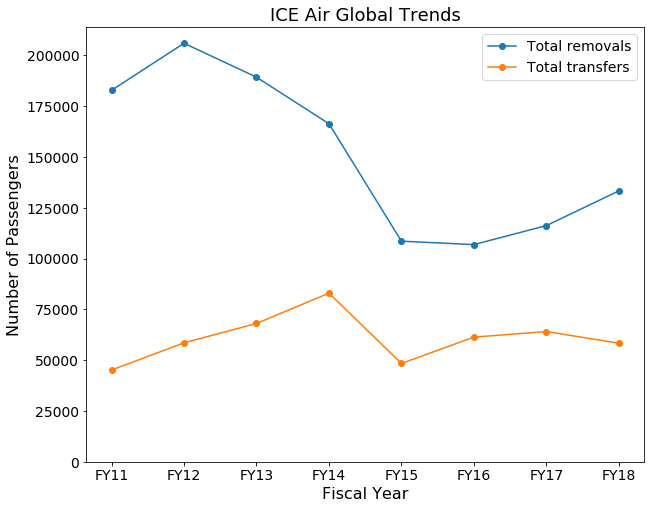

In [41]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(style='o-', legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'ICE Air Global Trends', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/ICE-Air-Global-Trends.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_removals['2010':'2017'], annual_transfers['2010':'2017']]);

In [42]:
# Change groupby to `transfer_df` to get table/figure of transfer nationalities
g = removal_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [43]:
country_of_citizenship_by_year.head()

,CountryOfCitizenship,AlienMasterID,MissionID
FY,,,
2011-10-01,MEXICO,110870,1234
2010-10-01,MEXICO,108021,1222
2012-10-01,MEXICO,78650,972
2013-10-01,GUATEMALA,54270,467
2017-10-01,GUATEMALA,48765,438


In [44]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

In [45]:
top_5_data

CountryOfCitizenship,ALL OTHERS,DOMINICAN REPUBLIC,EL SALVADOR,GUATEMALA,HAITI,HONDURAS,MEXICO
FY11,4968,2343,15817,30475,0,21183,108021
FY12,5480,2281,18108,38400,0,30815,110870
FY13,4869,1849,20178,47956,0,35759,78650
FY14,4720,1748,26508,54270,0,39827,39279
FY15,3952,1552,21378,32599,0,19613,29461
FY16,3881,1556,20089,32963,0,21311,27082
FY17,6306,0,17970,32198,5549,21241,32967
FY18,5973,1520,14516,48765,0,27777,34738
FY19,1002,334,2976,9157,0,6376,5387


In [ ]:
top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]
top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

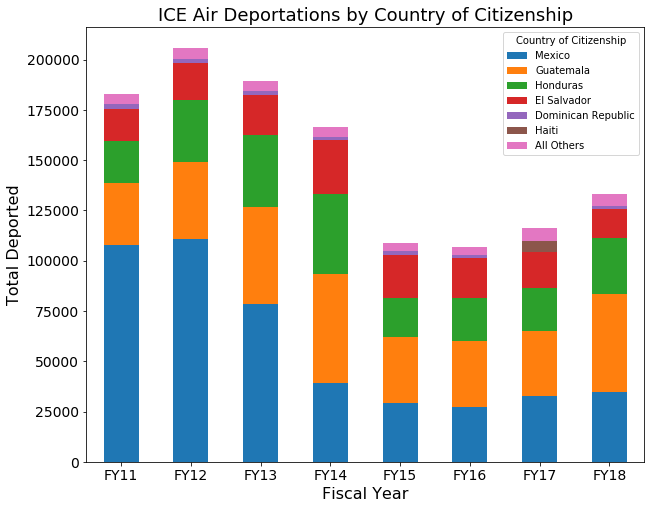

In [101]:
def country_of_citizenship_trend(data, title=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    filename = title.replace(' ', '-')
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

country_of_citizenship_trend(top_5_data.drop('FY19'),
                             title='ICE Air Deportations by Country of Citizenship',
                             ylabel='Total Deported',
                             xlabel='Fiscal Year');